In [1]:
import pandas as pd
import io
import requests
from datetime import datetime
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def loadfiles():
    prefix = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    filenames={'confirmed':'time_series_covid19_confirmed_global.csv',
       'deaths':'time_series_covid19_deaths_global.csv',
       'recovered':'time_series_covid19_recovered_global.csv',
       }
    result={}
    for file in filenames.keys():
        url = prefix+filenames[file]
        s=requests.get(url).content
        result[file]=pd.read_csv(io.StringIO(s.decode('utf-8')))
    return result
files = loadfiles()
        

In [2]:
def transform_vals(files,name):
    values = defaultdict(list)
    df = files[name]
    dates = [datetime.strptime(d,'%m/%d/%y') for d in df.columns[4:]]
    for row in df.iterrows():
        vals = row[1][4:]
        province_state = row[1][0]
        country = row[1][1]
        lat = row[1][2]
        lon = row[1][3]
        for i in range(len(vals)):
            values['province_state'].append(province_state)
            values['country'].append(country)
            values['lat'].append(lat)
            values['lon'].append(lon)
            values['date'].append(dates[i])
            values[name].append(vals[i])
    return values

def loadOther(files,name):
    df = pd.DataFrame.from_dict(transform_vals(files,name))
    del df['lat']
    del df['lon']
    return df

def loadDF(files):
    df = pd.DataFrame.from_dict(transform_vals(files,'confirmed'))
    df = df.merge(loadOther(files,'deaths'),on=['country','province_state','date'])
    df = df.merge(loadOther(files,'recovered'),on=['country','province_state','date'])
    df['active']= df['confirmed']-(df['deaths']+df['recovered'])
    return df


df = loadDF(files)
df.to_csv('data.csv')
del df['lat']
del df['lon']

displaydate = max(df['date'])
#displaydate = '2020/03/10'
print(displaydate)
df[df['date']==displaydate][['confirmed','deaths','recovered','active']].sum()

2020-05-22 00:00:00


confirmed    5126870
deaths        331800
recovered    2014035
active       2781035
dtype: int64

In [3]:
df[df['date']==displaydate].groupby(['country']).sum().sort_values(by=['confirmed'], ascending=False)

,confirmed,deaths,recovered,active
country,,,,
US,1600937,95979,350135,1154823
Brazil,330890,21048,135430,174412
Russia,326448,3249,99825,223374
United Kingdom,255544,36475,1142,217927
Spain,234824,28628,150376,55820
Italy,228658,32616,136720,59322
France,182015,28218,63986,89811
Germany,179710,8228,159064,12418
Turkey,154500,4276,116111,34113


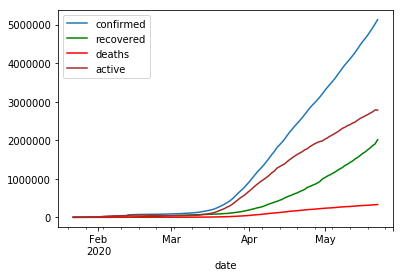

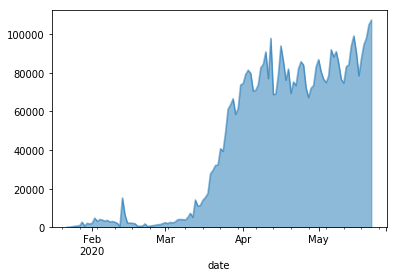

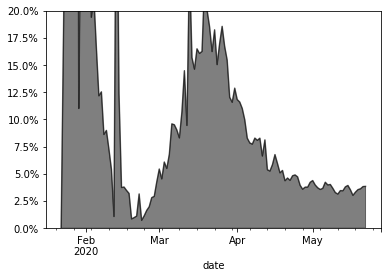

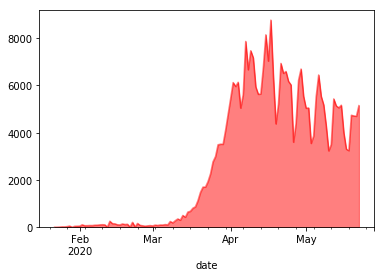

In [4]:
def plotvals(df):
    df=df.groupby(['date']).sum()
    ax = plt.gca()
    df.plot(kind='line',y='confirmed',ax=ax)
    df.plot(kind='line',y='recovered',color='green', ax=ax)
    df.plot(kind='line',y='deaths', color='red', ax=ax)
    df.plot(kind='line',y='active', color='brown', ax=ax)
    plt.show()
def plot_daily_change(df):
    diff = df.groupby(['date']).sum()['confirmed'].diff()
    diff.plot(kind='area',y='confirmed',stacked=False)
    plt.show()

def plot_daily_change_deaths(df):
    diff = df.groupby(['date']).sum()['deaths'].diff()
    diff.plot(kind='area',y='deaths',color='red',stacked=False)
    plt.show()
    
def plot_daily_change_percent(df):
    ax = plt.gca()
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    confirmed = df.groupby(['date']).sum()['confirmed']
    active = (df.groupby(['date']).sum()['active'])
    result = confirmed.diff()/(active).shift(1)
    result.plot(kind='area',y='confirmed',color='black',stacked=False,ax=ax)
    plt.ylim([0,0.20])
    plt.show()
    
plotvals(df)
plot_daily_change(df)
plot_daily_change_percent(df)
plot_daily_change_deaths(df)

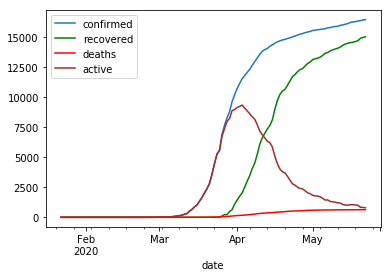

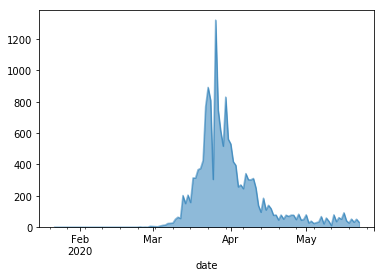

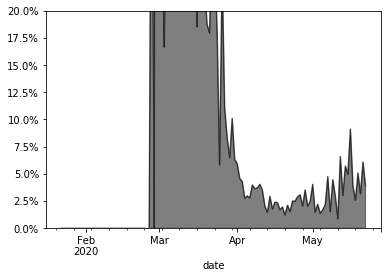

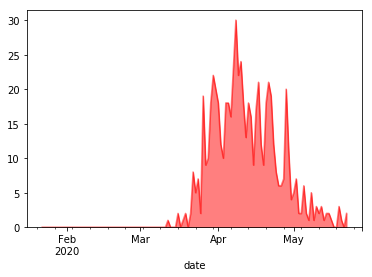

In [5]:
plotvals(df[df['country']=='Austria'])
plot_daily_change(df[df['country']=='Austria'])
plot_daily_change_percent(df[df['country']=='Austria'])
plot_daily_change_deaths(df[df['country']=='Austria'])

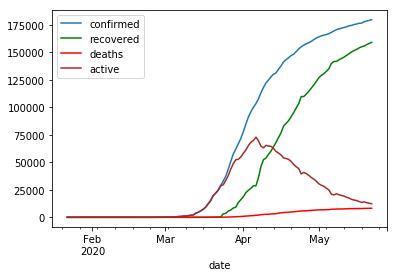

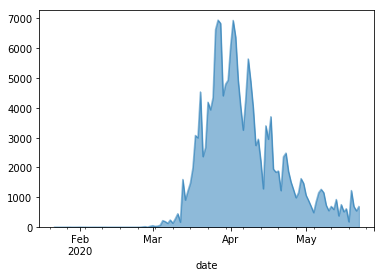

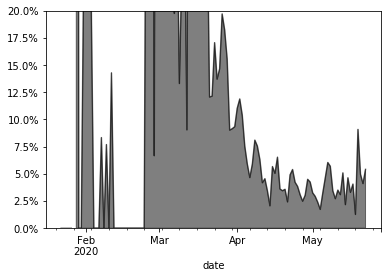

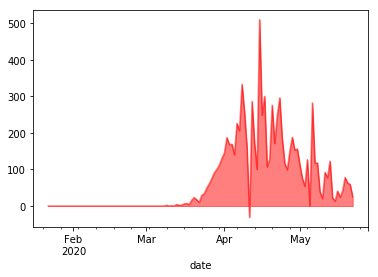

In [6]:
plotvals(df[df['country']=='Germany'])
plot_daily_change(df[df['country']=='Germany'])
plot_daily_change_percent(df[df['country']=='Germany'])
plot_daily_change_deaths(df[df['country']=='Germany'])

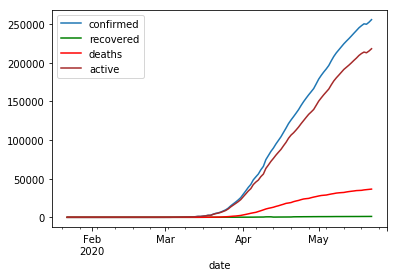

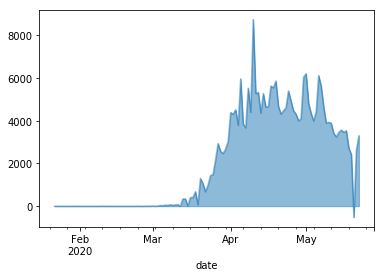

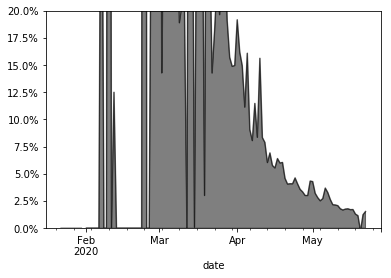

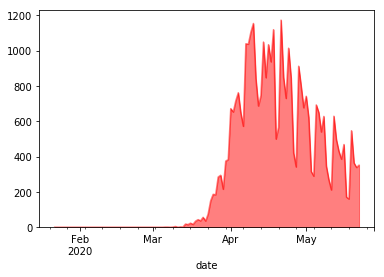

In [7]:
plotvals(df[df['country']=='United Kingdom'])
plot_daily_change(df[df['country']=='United Kingdom'])
plot_daily_change_percent(df[df['country']=='United Kingdom'])
plot_daily_change_deaths(df[df['country']=='United Kingdom'])

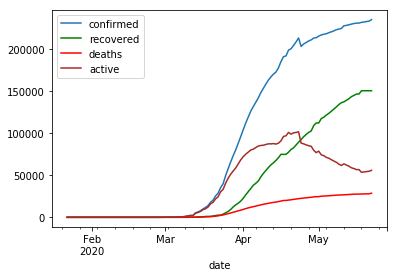

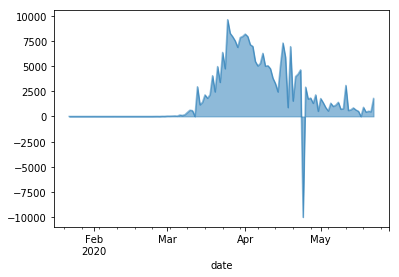

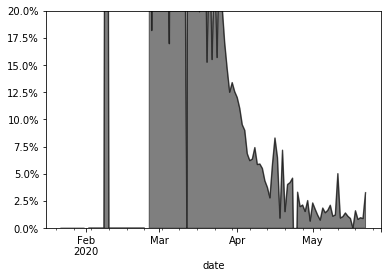

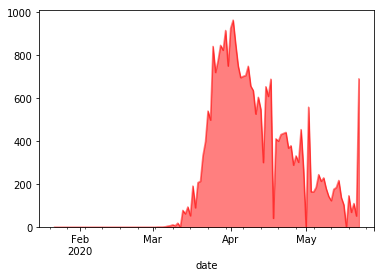

In [8]:
plotvals(df[df['country']=='Spain'])
plot_daily_change(df[df['country']=='Spain'])
plot_daily_change_percent(df[df['country']=='Spain'])
plot_daily_change_deaths(df[df['country']=='Spain'])

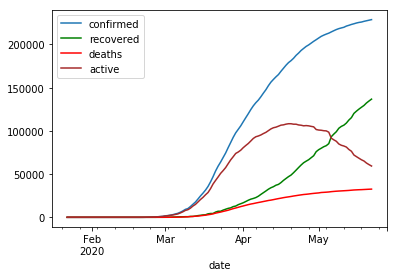

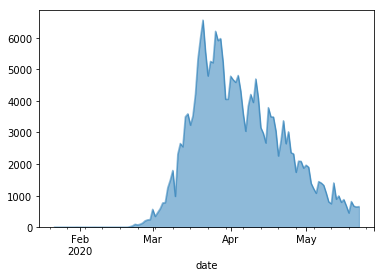

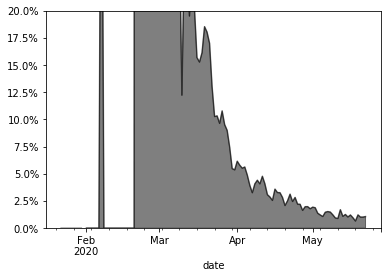

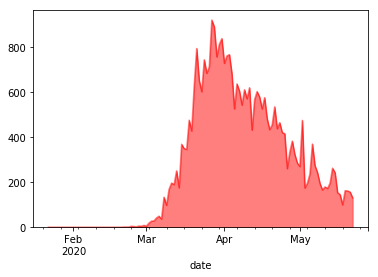

In [9]:
plotvals(df[df['country']=='Italy'])
plot_daily_change(df[df['country']=='Italy'])
plot_daily_change_percent(df[df['country']=='Italy'])
plot_daily_change_deaths(df[df['country']=='Italy'])


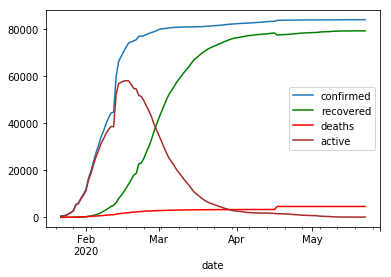

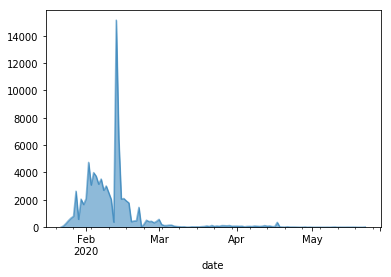

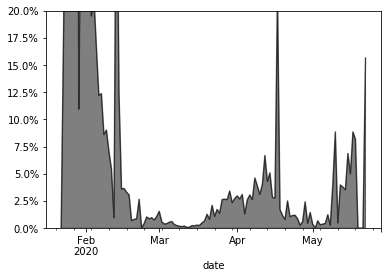

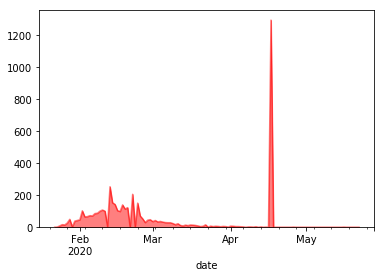

In [10]:
plotvals(df[df['country']=='China'])
plot_daily_change(df[df['country']=='China'])
plot_daily_change_percent(df[df['country']=='China'])
plot_daily_change_deaths(df[df['country']=='China'])


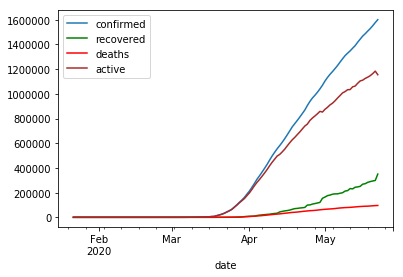

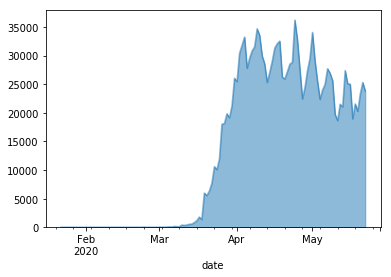

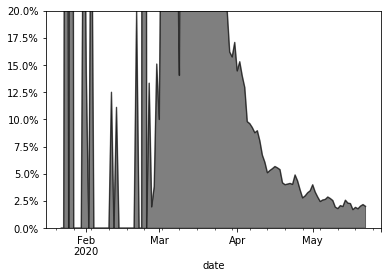

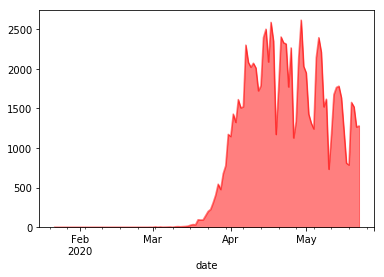

In [11]:
plotvals(df[df['country']=='US'])
plot_daily_change(df[df['country']=='US'])
plot_daily_change_percent(df[df['country']=='US'])
plot_daily_change_deaths(df[df['country']=='US'])


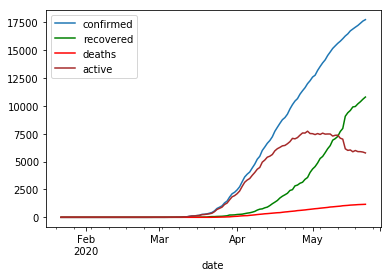

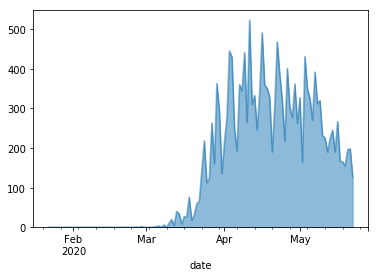

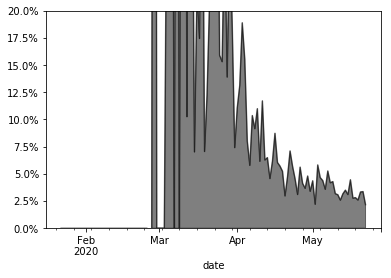

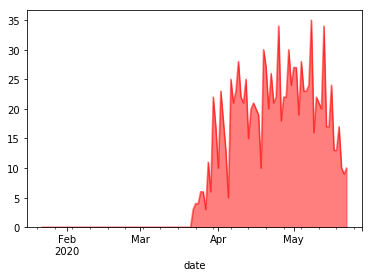

In [12]:
plotvals(df[df['country']=='Romania'])
plot_daily_change(df[df['country']=='Romania'])
plot_daily_change_percent(df[df['country']=='Romania'])
plot_daily_change_deaths(df[df['country']=='Romania'])

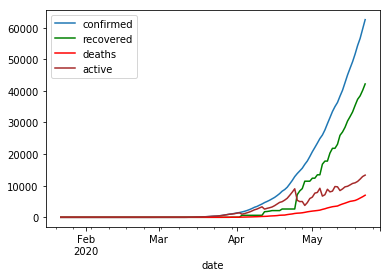

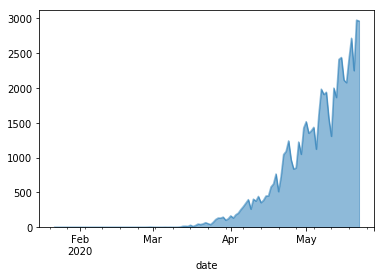

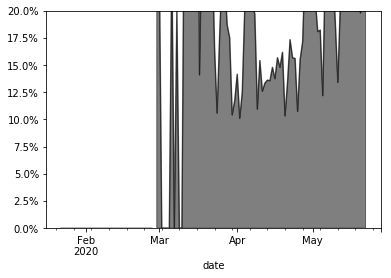

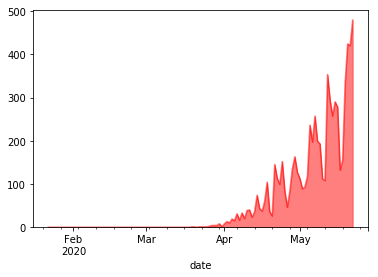

In [13]:
plotvals(df[df['country']=='Mexico'])
plot_daily_change(df[df['country']=='Mexico'])
plot_daily_change_percent(df[df['country']=='Mexico'])
plot_daily_change_deaths(df[df['country']=='Mexico'])

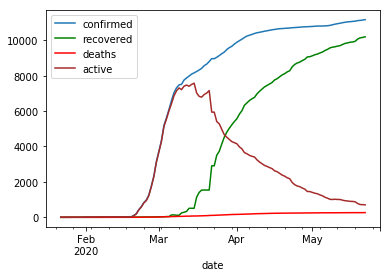

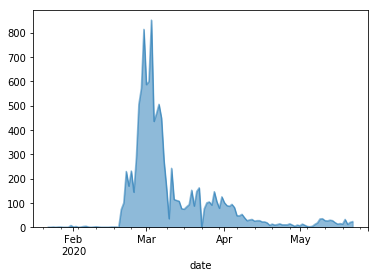

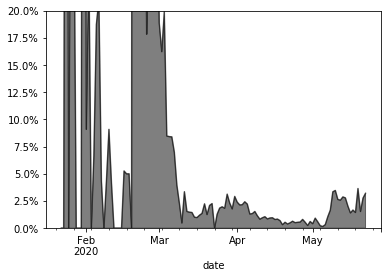

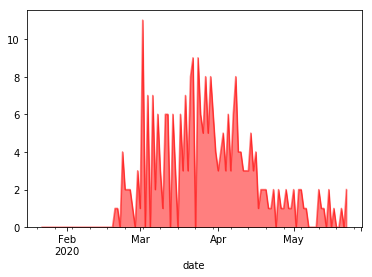

In [14]:
plotvals(df[df['country']=='Korea, South'])
plot_daily_change(df[df['country']=='Korea, South'])
plot_daily_change_percent(df[df['country']=='Korea, South'])
plot_daily_change_deaths(df[df['country']=='Korea, South'])